In [1]:
from dataclasses import dataclass
import torch
from torch import nn
import lightning as L

from model import LitBlockEmbeddingModel, BlockEmbeddingModel

@dataclass
class BlockEmbeddingParams:
    # skipgram parameters
    CONTEXT_DISTANCE = 2  # window will be `(CONTEXT_DISTANCE * 2 + 1) ** 3`

    # model parameters
    VOCAB_SIZE = 70
    EMBED_DIM = 50
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # training parameters
    SUBSAMPLING_T = 85
    SUBSAMPLING_UNKNOWN_WORD_FREQUENCY = 4680568 # about four times the total token for building the vocab, the rate of sampling unknown words can be a bit small
    BATCH_SIZE = 8192
    N_EPOCHS = 5
    SAVE_EVERY_N_STEPS = 10000
    TOTAL_STEP_ESTIMATE = 150000

    # dataset parameters
    MINECRAFT_WORLD_DIR = 'saves/TrainingWorld3'
    # bigger number on each direction automatically being the end side, and is not included. The last a few x coordinates might be dropped if does not divide into workers
    MINECRAFT_WORLD_REGION = ((0, 0, 0), (-2000, 80, 64))

params = BlockEmbeddingParams()

lit_embedding_model = LitBlockEmbeddingModel.load_from_checkpoint('BlockEmbedding/0_distance_2_dim_50/checkpoints/epoch=0-step=50000.ckpt', params=params)

In [2]:
print(lit_embedding_model.model.t_embeddings(torch.tensor(range(4), device='cuda')))

tensor([[ 0.3747, -0.1718,  0.1290,  0.1101,  0.7168, -1.3330, -0.1947,  0.6154,
         -0.3705, -0.7439,  0.1648, -1.7826, -1.3909,  0.5259,  0.9674,  1.3567,
         -0.4739, -1.4101, -0.4915,  1.7517,  1.1945, -1.0773, -0.0863,  0.3903,
          0.6355, -0.3434,  0.4529, -0.1319, -0.3215,  1.0825, -1.1121, -0.8470,
          0.7690, -0.3400,  1.4695, -0.4406,  0.0860, -0.5298, -0.0610, -0.0108,
         -0.2190, -0.4219,  1.2796, -1.0749, -0.5453,  0.7978,  0.8827,  0.8522,
         -0.0902,  1.0939],
        [-1.3930, -0.7425,  2.4970,  2.0171, -1.3458,  0.6182, -1.0526,  0.1911,
         -0.3215, -0.5748, -0.0545, -0.4483, -0.9346, -0.4964,  0.0265,  0.1687,
         -1.0610,  1.3759,  1.6419, -0.0453,  0.1684,  0.6846, -0.5731,  0.2542,
          0.5561, -0.7028, -0.3553, -0.5233,  0.4066,  0.5656,  0.4371, -2.2306,
          1.5713,  1.0287,  0.6223,  0.8542,  1.2258, -0.2036,  1.1093, -0.8738,
         -1.0435,  0.2823,  0.8875,  0.6804,  0.1304,  0.0135, -0.1151, -1.4530,


In [73]:
from utils import load_block_index_map
import random
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torch.nn import Embedding
block_index_map = load_block_index_map()
block_texture_map = {
    'grass_block': 'grass_block_side',
    'lava': 'lava_still',
    'tall_grass': 'tall_grass_top',
    'tall_seagrass': 'tall_seagrass_top',
    'large_fern': 'large_fern_top',
    'sunflower': 'sunflower_front',
    'lilac': 'lilac_top',
    'peony': 'peony_top',
    'wall_torch': 'torch',
}

[Errno 2] No such file or directory: 'textures/block/air.png'
[Errno 2] No such file or directory: 'textures/block/water.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/infested_stone.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/chest.png'
[Errno 2] No such file or directory: 'textures/block/unknown.png'


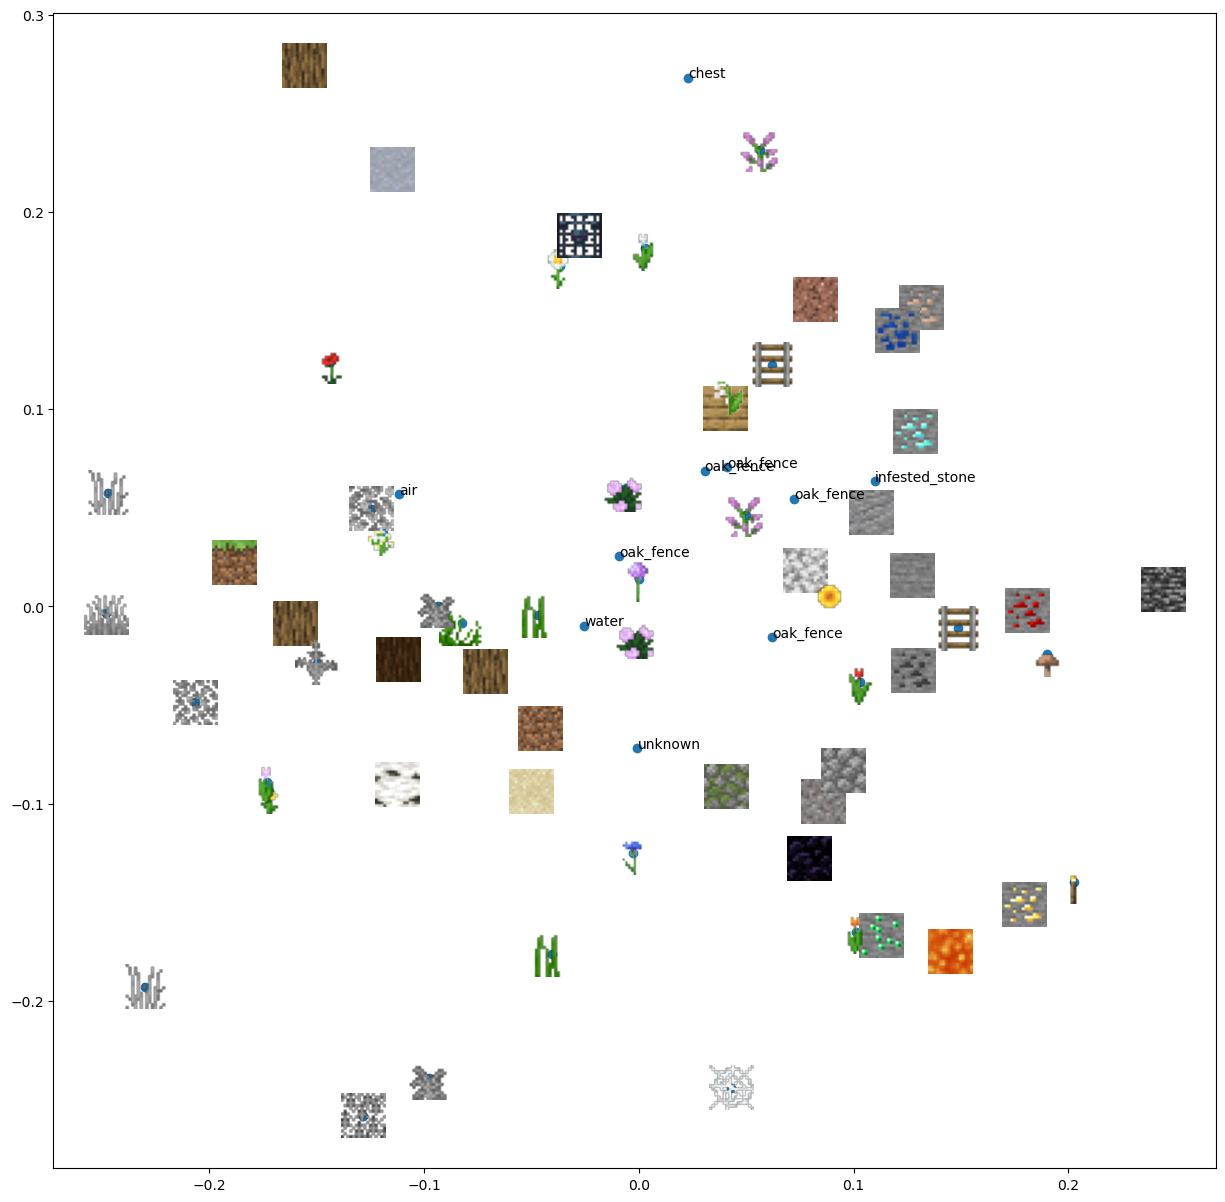

In [75]:
from utils import Word


embeddings = lit_embedding_model.model.t_embeddings(torch.tensor(range(params.VOCAB_SIZE + 1), device='cuda'))
embeddings_pca = torch.pca_lowrank(embeddings, q=2)[0].detach().cpu()

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])

block_names = ['unknown'] * len(embeddings)
for name, l in block_index_map.items():
    word: Word
    for word in l:
        block_names[word.index] = name[len('minecraft:'):]

for i, block_name in enumerate(block_names):
    x, y = (embeddings_pca[i, 0], embeddings_pca[i, 1])
    try:
        if block_name in block_texture_map:
            texture = block_texture_map[block_name]
        else:
            texture = block_name
        im = OffsetImage(plt.imread(f'textures/block/{texture}.png')[:16, :16, :], zoom=2)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except Exception as exception:
        print(exception)
        ax.text(x, y, block_name) # crashes CUDA the 2nd time if block_name is not str or is empty

[Errno 2] No such file or directory: 'textures/block/air.png'
[Errno 2] No such file or directory: 'textures/block/water.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/infested_stone.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/chest.png'
[Errno 2] No such file or directory: 'textures/block/unknown.png'


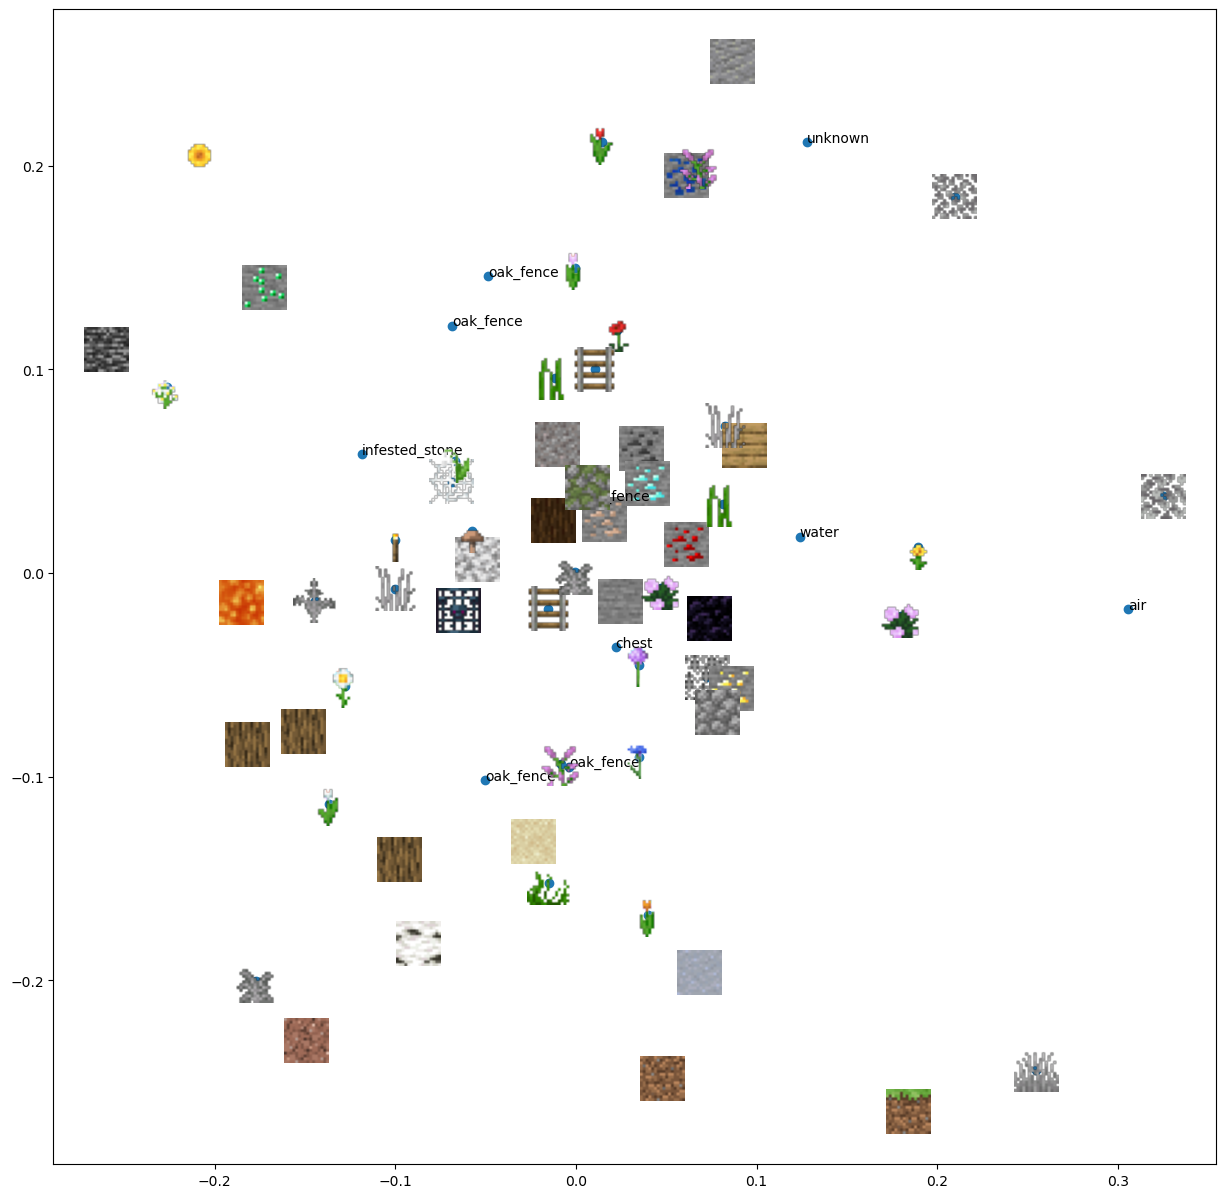

In [88]:
@dataclass
class BlockEmbeddingParams:
    # skipgram parameters
    CONTEXT_DISTANCE = 1  # window will be `(CONTEXT_DISTANCE * 2 + 1) ** 3`

    # model parameters
    VOCAB_SIZE = 70
    EMBED_DIM = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # training parameters
    SUBSAMPLING_T = 85
    SUBSAMPLING_UNKNOWN_WORD_FREQUENCY = 4680568 # about four times the total token for building the vocab, the rate of sampling unknown words can be a bit small
    BATCH_SIZE = 8192
    N_EPOCHS = 5
    SAVE_EVERY_N_STEPS = 10000
    TOTAL_STEP_ESTIMATE = 150000

    # dataset parameters
    MINECRAFT_WORLD_DIR = 'saves/TrainingWorld3'
    # bigger number on each direction automatically being the end side, and is not included. The last a few x coordinates might be dropped if does not divide into workers
    MINECRAFT_WORLD_REGION = ((0, 0, 0), (-2000, 80, 64))

params = BlockEmbeddingParams()

model = BlockEmbeddingModel(params)
lit_embedding_model = LitBlockEmbeddingModel.load_from_checkpoint('BlockEmbedding/1_distance_1_dim_3/checkpoints/epoch=0-step=10000.ckpt', params=params, model=model)

embeddings = lit_embedding_model.model.t_embeddings(torch.tensor(range(params.VOCAB_SIZE + 1), device='cuda'))
embeddings_pca = torch.pca_lowrank(embeddings, q=2)[0].detach().cpu()

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])

block_names = ['unknown'] * len(embeddings)
for name, l in block_index_map.items():
    word: Word
    for word in l:
        block_names[word.index] = name[len('minecraft:'):]

for i, block_name in enumerate(block_names):
    x, y = (embeddings_pca[i, 0], embeddings_pca[i, 1])
    try:
        if block_name in block_texture_map:
            texture = block_texture_map[block_name]
        else:
            texture = block_name
        im = OffsetImage(plt.imread(f'textures/block/{texture}.png')[:16, :16, :], zoom=2)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except Exception as exception:
        print(exception)
        ax.text(x, y, block_name) # crashes CUDA the 2nd time if block_name is not str or is empty

[Errno 2] No such file or directory: 'textures/block/air.png'
[Errno 2] No such file or directory: 'textures/block/water.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/infested_stone.png'
[Errno 2] No such file or directory: 'textures/block/oak_fence.png'
[Errno 2] No such file or directory: 'textures/block/chest.png'
[Errno 2] No such file or directory: 'textures/block/unknown.png'


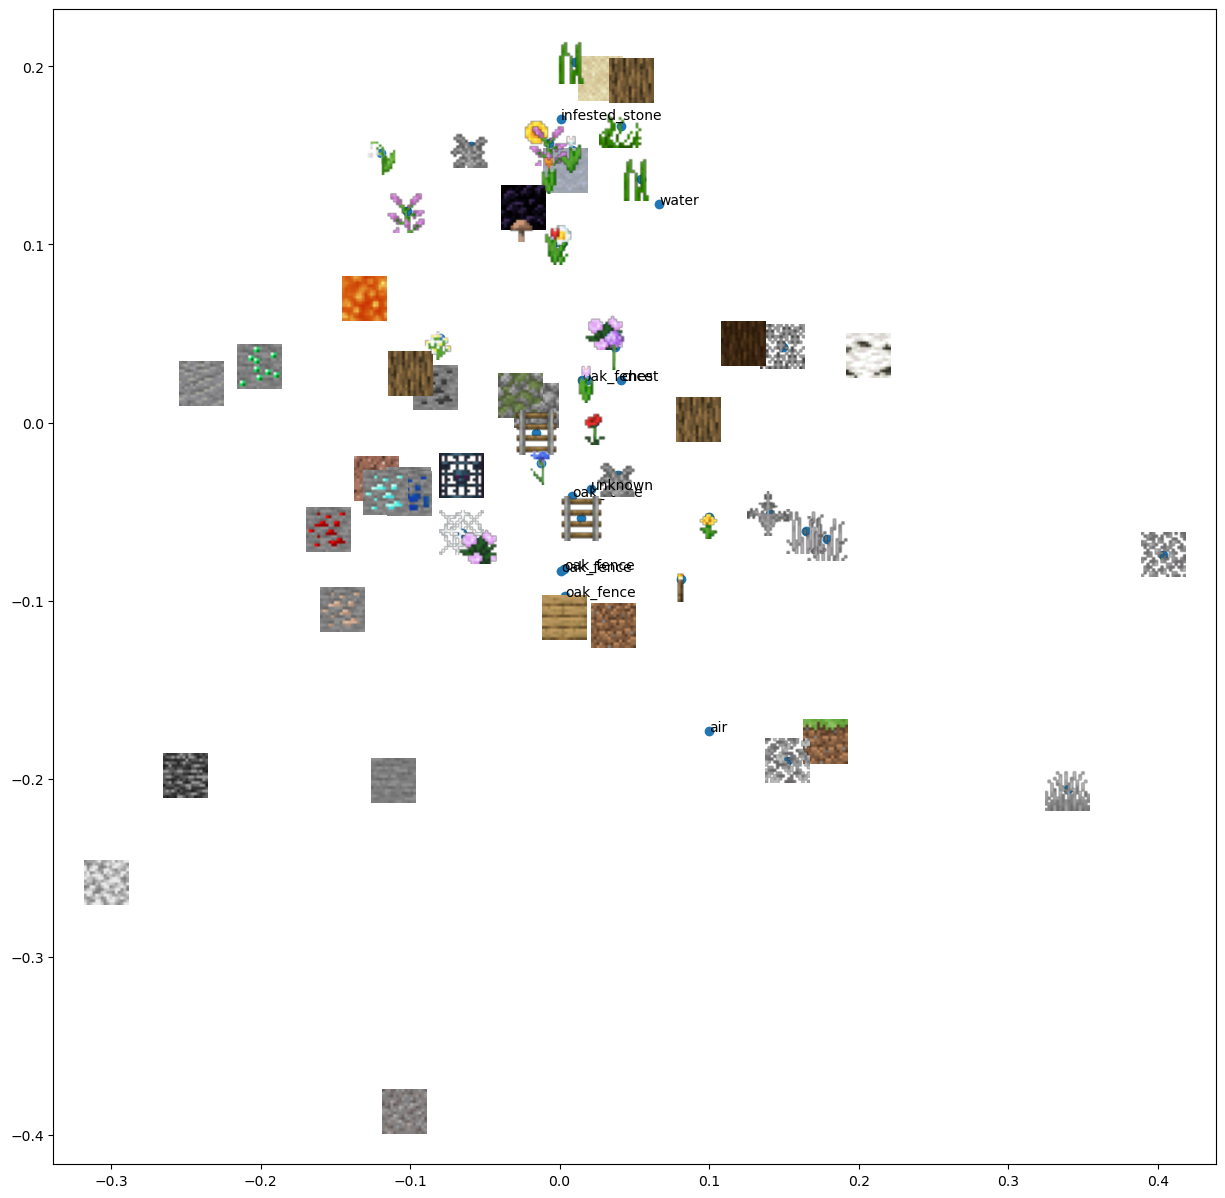

In [90]:
@dataclass
class BlockEmbeddingParams:
    # skipgram parameters
    CONTEXT_DISTANCE = 1  # window will be `(CONTEXT_DISTANCE * 2 + 1) ** 3`

    # model parameters
    VOCAB_SIZE = 70
    EMBED_DIM = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # training parameters
    SUBSAMPLING_T = 85
    SUBSAMPLING_UNKNOWN_WORD_FREQUENCY = 4680568 # about four times the total token for building the vocab, the rate of sampling unknown words can be a bit small
    BATCH_SIZE = 8192
    N_EPOCHS = 5
    SAVE_EVERY_N_STEPS = 10000
    TOTAL_STEP_ESTIMATE = 150000

    # dataset parameters
    MINECRAFT_WORLD_DIR = 'saves/TrainingWorld3'
    # bigger number on each direction automatically being the end side, and is not included. The last a few x coordinates might be dropped if does not divide into workers
    MINECRAFT_WORLD_REGION = ((0, 0, 0), (-2000, 80, 64))

params = BlockEmbeddingParams()

model = BlockEmbeddingModel(params)
lit_embedding_model = LitBlockEmbeddingModel.load_from_checkpoint('BlockEmbedding/2_distance_1_dim_3/checkpoints/epoch=0-step=30000.ckpt', params=params, model=model)

embeddings = lit_embedding_model.model.t_embeddings(torch.tensor(range(params.VOCAB_SIZE + 1), device='cuda'))
embeddings_pca = torch.pca_lowrank(embeddings, q=2)[0].detach().cpu()

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])

block_names = ['unknown'] * len(embeddings)
for name, l in block_index_map.items():
    word: Word
    for word in l:
        block_names[word.index] = name[len('minecraft:'):]

for i, block_name in enumerate(block_names):
    x, y = (embeddings_pca[i, 0], embeddings_pca[i, 1])
    try:
        if block_name in block_texture_map:
            texture = block_texture_map[block_name]
        else:
            texture = block_name
        im = OffsetImage(plt.imread(f'textures/block/{texture}.png')[:16, :16, :], zoom=2)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except Exception as exception:
        print(exception)
        ax.text(x, y, block_name) # crashes CUDA the 2nd time if block_name is not str or is empty